In [1]:
import torch

import pyprob
from pyprob import Model
import pyprob.distributions as dists

import calendar
import string

In [2]:
class OneHot2DCategorical(dists.Categorical):
    def sample(self):
        s = self._torch_dist.sample()
        one_hot = self._probs * 0
        for i, val in enumerate(s):
            one_hot[i, int(val.item())] = 1
        return one_hot
    
    def log_prob(self, x, *args, **kwargs):
        # vector of one hot vectors
        non_one_hot = torch.tensor([row.nonzero() for row in x])
        return super().log_prob(non_one_hot, *args, **kwargs)

In [3]:
class DateParser(Model):
    def __init__(self):
        super().__init__(name="Date with Unkown Format")
        self.possible_dividers = ['\\', '/', '-', ' ', '_', ':', '.']
        self.longest_string = len('31 / September / 2000')
        self.all_symbols = list(string.ascii_uppercase) + \
                           [str(d) for d in range(10)] + \
                           self.possible_dividers + \
                           [' ']
    def get_index(self, letter):
        return self.all_symbols.index(letter)
    def pad(self, date_string):
        return date_string + ' ' * (self.longest_string - len(date_string))
    def forward(self):
        # all dates are between 0 AD and 4000 AD
        # sanple each digit such that the year is usually close to 2019
        year_1 = int(pyprob.sample(dists.Categorical(torch.tensor(
            [0.05, 0.4, 0.4, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
        ))).item())
        year_2 = int(pyprob.sample(dists.Categorical(torch.tensor(
            [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.16, 0.7] if year_1 == 1 else
            [0.7, 0.16, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02] if year_1 == 2 else
            [0.1]*10
        ))).item())
        year_3 = int(pyprob.sample(dists.Categorical(torch.tensor([0.1]*10))).item())
        year_4 = int(pyprob.sample(dists.Categorical(torch.tensor([0.1]*10))).item())
        year = int("".join(str(d) for d in [year_1, year_2, year_3, year_4]))
        # sample month and day given the year
        month = int(pyprob.sample(dists.Categorical(torch.tensor([1/12]*12))).item()) +1
        if year == 0:
            num_days = 31    # monthrange fails if year is 0
        else:
            num_days = calendar.monthrange(year, month)[1]             # number of days in this month
        day_probs = [1/num_days]*num_days + [0.]*(31-num_days)     # probs of which day it is (in fixed length vector)
        day = int(pyprob.sample(dists.Categorical(torch.tensor(day_probs))).item()) + 1
        # sample format used to write day, month and year
        yy = pyprob.sample(dists.Categorical(torch.tensor([0.5, 0.5]))).item()  # either yy or yyyy
        m = pyprob.sample(dists.Categorical(torch.tensor([0.25]*4))).item()   # either m, mm or e.g. 'JAN'
        d = pyprob.sample(dists.Categorical(torch.tensor([0.5, 0.5]))).item()   # either d or dd
        real_date = {'day': day, 'month': month, 'year': year}
        # put day, month and year in right format
        if d:
            day = str(day)
        else:  # dd format
            day = str(day).zfill(2)
        # do month
        if m == 0:
            month = str(month)
        elif m == 1:
            month = str(month).zfill(2)
        elif m == 2:
            month = calendar.month_name[month]
        else:
            month = calendar.month_abbr[month]
        # do year
        if yy:
            year = str(year).zfill(2)[-2:]
        else:  # yyyy
            year = str(year).zfill(4)
        # sample order of day, month, year
        # m/d/y or d/m/y or y/m/d (never y/d/m)
        order = pyprob.sample(dists.Categorical(torch.tensor([1/3]*3))).item()
        if order == 0:
            date = [month, day, year]
        elif order == 1:
            date = [day, month, year]
        else:
            date = [year, month, day]
        # select dividers
        num_div = len(self.possible_dividers)
        divider1 = int(pyprob.sample(dists.Categorical(torch.tensor([1/num_div]*num_div))).item())
        divider2 = int(pyprob.sample(dists.Categorical(torch.tensor([1/num_div]*num_div))).item())
        divider1 = self.possible_dividers[divider1]
        divider2 = self.possible_dividers[divider2]
        # sometimes put space before/after dividers
        space1 = bool(pyprob.sample(dists.Categorical(torch.tensor([0.9, 0.1]))).item())
        space2 = bool(pyprob.sample(dists.Categorical(torch.tensor([0.9, 0.1]))).item())
        space3 = bool(pyprob.sample(dists.Categorical(torch.tensor([0.9, 0.1]))).item())
        space4 = bool(pyprob.sample(dists.Categorical(torch.tensor([0.9, 0.1]))).item())
        date =  "".join([date[0],
                         ' ' if space1 else '',
                         divider1,
                         ' ' if space2 else '',
                         date[1],
                         ' ' if space3 else '',
                         divider2,
                         ' ' if space4 else '',
                         date[2]]).upper()
        # pad with spaces so tha number of observations is constant
        padded_date = self.pad(date)
        # make a categorical distribution that observes each letter independently (like 20 independent categoricals)
        probs = torch.ones(self.longest_string, len(self.all_symbols))*0.001
        for i, letter in enumerate(padded_date):
            probs[i, self.get_index(letter)] = 1.
        pyprob.observe(OneHot2DCategorical(probs),
                       name=f"date_string")
        
        return real_date
    def get_observes(self, date_string):
        one_hot = torch.zeros(self.longest_string, len(self.all_symbols))
        date_string = self.pad(date_string.upper())
        for i, letter in enumerate(date_string):
            one_hot[i, self.get_index(letter)] = 1.
        return {'date_string': one_hot}


In [4]:
model = DateParser()
model.load_inference_network('artifacts/date-parser-5000000')

/home/will/anaconda3/lib/python3.6/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleDict' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/will/anaconda3/lib/python3.6/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/will/anaconda3/lib/python3.6/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing 

In [5]:
post = model.posterior_distribution(
    observe=model.get_observes('12thSEPTEMBOR 2009'),
    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK,
    num_traces=10
)
print(post.sample())
print(post.sample())
print(post.sample())

Time spent  | Time remain.| Progress             | Trace | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 10/10 | 31.43       
{'day': 12, 'month': 9, 'year': 2009}
{'day': 12, 'month': 9, 'year': 2009}
{'day': 12, 'month': 9, 'year': 2009}


Text(0, 0.5, 'Loss')

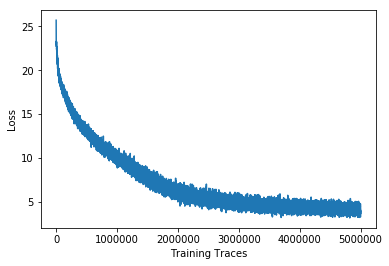

In [6]:
import matplotlib.pyplot as plt
plt.plot([i*128 for i, _ in enumerate(model._inference_network._history_train_loss)],
         model._inference_network._history_train_loss)
plt.xlabel('Training Traces')
plt.ylabel('Loss')